Gradient boosting works in the following way:

1) Start with a constant prediction (this is going to be a very weak prediction) - usually the average of all the classes in some sense. Call this prediction $F_0(x)$. For the case of binary classification, the inital constant prediction, will have the odds $\hat{y} = \log (\# \, 1 \, labels  / \# \, 0 \, labels )$ or $p = \# \, 1\, labels / total \, examples$.
2) Define a suitable loss function. In the case of regressors, this may be an MSE, and in the case of a classifier, it is the cross entropy (dynamic part of the K-L divergence). For classifiers, we have $$L(y_i, \hat{y}_i) =- \sum_{j = 1}^c y_i \log \hat{y}_{i,j}.$$
3) We will train $M$ trees successively using the following steps:

    a) For tree $m+1$ on the $i^{th}$ data point, we compute the pseudo-residual $r_{im} = - \frac{\partial L(y_i, F_{m}(x_i))}{\partial F_m(x_i)}$, the direction to minimize the error on that data point.

    b) Fit a tree to predict these pseudo-residuals $r_{im}$ for the $m^{th}$ iteration. This will have $J_m$ leaf nodes. For each of these leaf nodes $R_{jm}$, compute the value of $\gamma$ that minimizes $\sum_{x_i \in R_{jm}} L(y_i, F_m(x_i) + \gamma)$ (where the sum is over all training examples that ended up in that leaf node) and denote that $\gamma_{m}$. Typically the sum here represents an average over all relevant examples that are left in the leaf nodes in the prediction corresponding to $x$.

    c) Then $F_{m+1}(x) \equiv F_{m}(x) + \eta \gamma_m(x)$, where $\eta$ is the learning rate.

In the case of binary classification, the loss for the $i^{th}$ data point will take the form $L_i = - y_i \log p_i + (1-y_i) \log(1-p_i)$ where $p_i$ is the predicted probability of obtaining $y_i = 1$. This can be considered in terms of the odds: $$\hat{y} = \log(odds )= \log\left( \frac{p}{1-p}\right) \iff p = \frac{1}{1 + \exp{-\hat{y}}}$$

Rewriting the loss in terms of $\hat{y}$, we get $$\frac{\partial L_i}{\partial \hat{y}_i} = \frac{\exp \hat{y}_i}{1 + \exp{\hat{y}_i}} - y_i = p_i - y_i $$

Plugging this into the equations above, we get $$\gamma_{jm} = \mathrm{arg min}_\gamma \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x_i) + \gamma) = \frac{\sum_i y_i -p_i}{\sum_i p_i (1-p_i)}$$

Note that this iterative gradient fit learning can result in the overfitting of a dataset.

There are many popular gradient boosting packages. 2 of the most popular ones are XGBoost and LightGBM.

XGBoost:

The model supports the following kinds of boosting:

- Gradient Boosting by learning rate.
- Stochastic Gradient Boosting that enables sampling at a row, column, or column per split level.
- $L_1$ and $L_2$ Regularized Gradient Boosting.

XGBoost grows evenly across tree-depth.


LightGBM:

The advantages are as follows:

- Faster training speed and accuracy resulting from LightGBM being a histogram-based algorithm that performs bucketing of values (also requires lesser memory).
- Also compatible with large and complex datasets but is much faster during training.
- Support for both parallel learning and GPU learning

LightGBM grows leaf-wise, not maintaining tree depth.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score

import os

original_dir = os.getcwd()
os.chdir('..')

from decision_plotting import DecisionRegionPlotter
os.chdir(original_dir)

drp = DecisionRegionPlotter()

In [2]:
rnd_state = 1

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
le = LabelEncoder()
y = le.fit_transform(y)
# This is the true test set. The split inside the sequential backward selection is for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
import xgboost as xgb

xbooster = xgb.XGBClassifier(n_estimators=1000,
                             learning_rate=0.01,
                             max_depth=4,
                             random_state=rnd_state,
                             use_label_encoder=False,)

xgbm = xbooster.fit(X_train, y_train)

train_acc_xgbm = accuracy_score(y_true=y_train, y_pred=xgbm.predict(X_train))
test_acc_xgbm = accuracy_score(y_true=y_test, y_pred=xgbm.predict(X_test))

print(f"Training accuracy for XGBoost: {train_acc_xgbm:.3f}")
print(f"Test accuracy for XGBoost: {test_acc_xgbm:.3f}")

c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:14:22] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training accuracy for XGBoost: 1.000
Test accuracy for XGBoost: 1.000


In [7]:
import lightgbm as lgb

lbooster = lgb.LGBMClassifier(n_estimators=1000,
                             learning_rate=0.01,
                             max_depth=4,
                             random_state=rnd_state,
                             n_jobs=-1)

lgbm = lbooster.fit(X_train, y_train)

train_acc_lgbm = accuracy_score(y_true=y_train, y_pred=lgbm.predict(X_train))
test_acc_lgbm = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))

print(f"Training accuracy for Light GBM: {train_acc_lgbm:.3f}")
print(f"Test accuracy for Light GBM: {test_acc_lgbm:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 13
[LightGBM] [Info] Start training from score -1.106709
[LightGBM] [Info] Start training from score -0.908259
[LightGBM] [Info] Start training from score -1.323774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Processed 73264 predictions in 8 batches
Processed 30228 predictions in 4 batches
Processed 520308 predictions in 53 batches


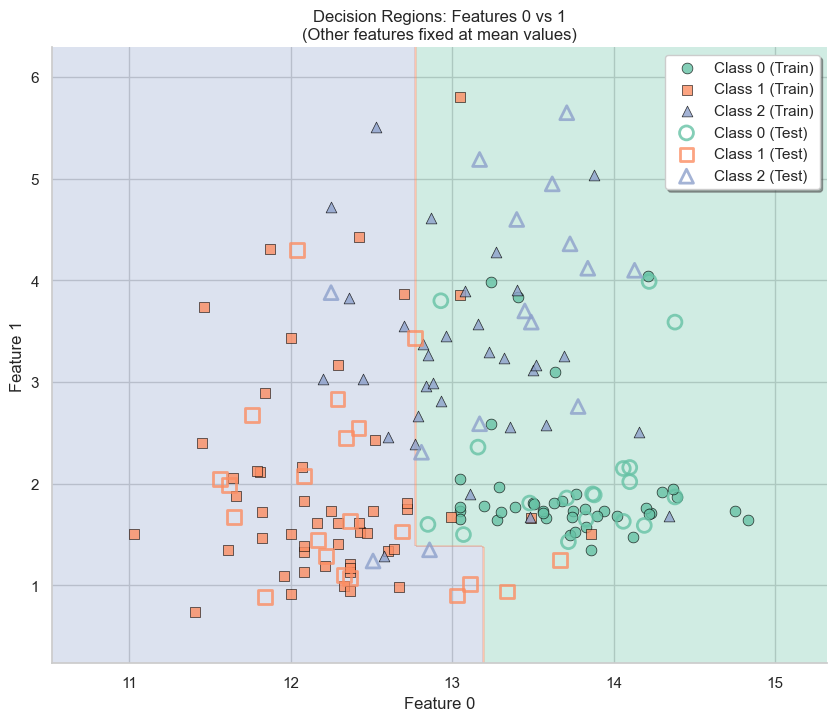

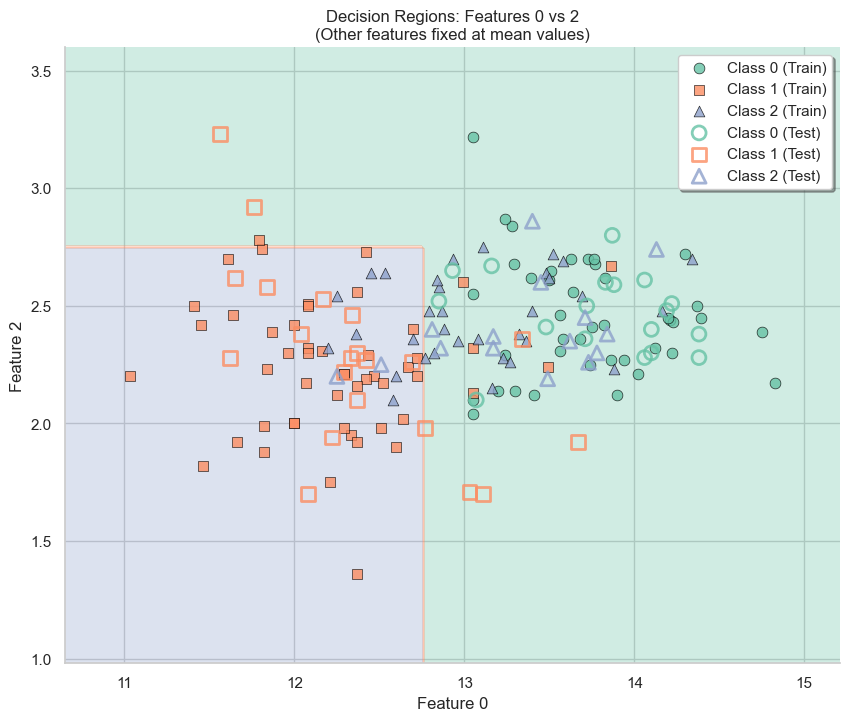

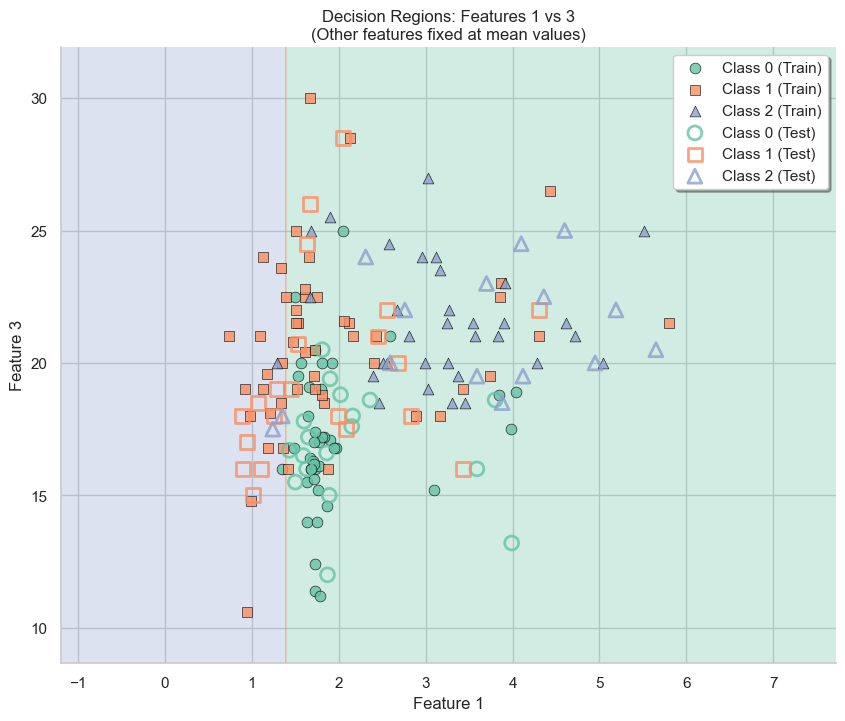

In [ ]:
drp = DecisionRegionPlotter()

drp.plot_decision_regions(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifier=xgbm, feature_indices=(0, 1))
drp.plot_decision_regions(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifier=xgbm, feature_indices=(0, 2))
drp.plot_decision_regions(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifier=xgbm, feature_indices=(1, 3))
plt.show()

c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, b

Processed 73264 predictions in 8 batches


c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Processed 30228 predictions in 4 batches


c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, b

Processed 520308 predictions in 53 batches


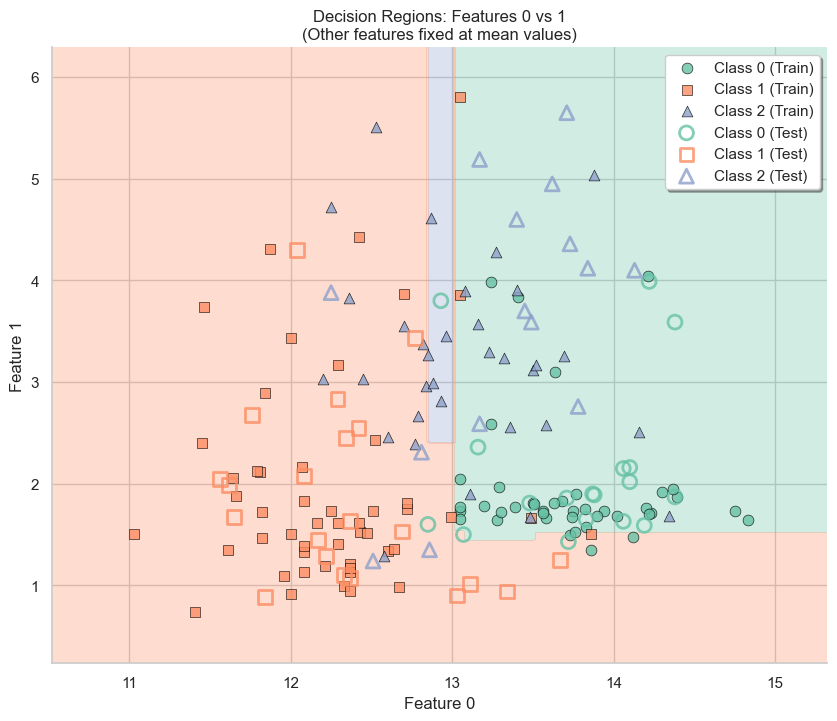

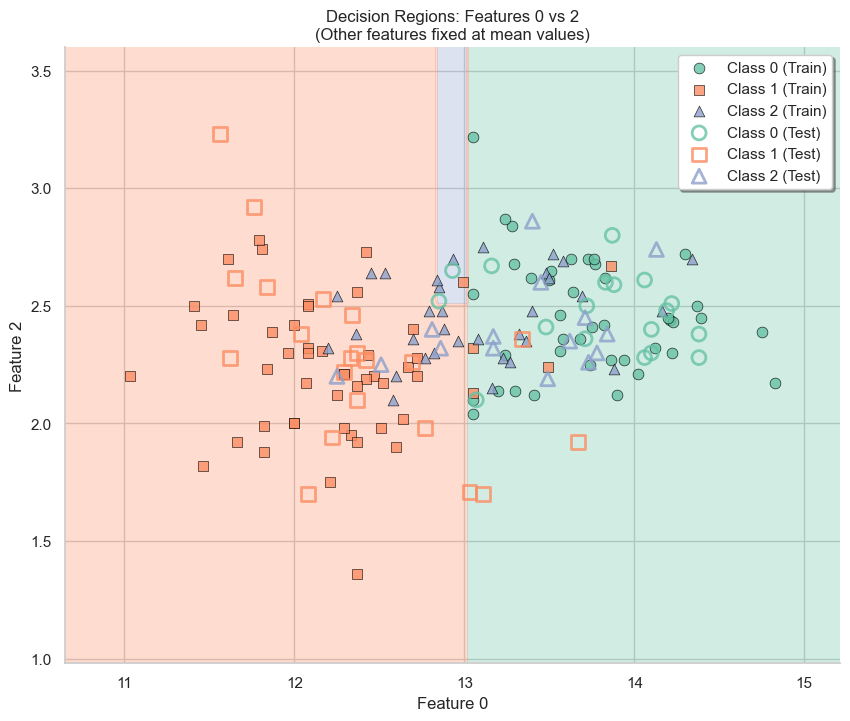

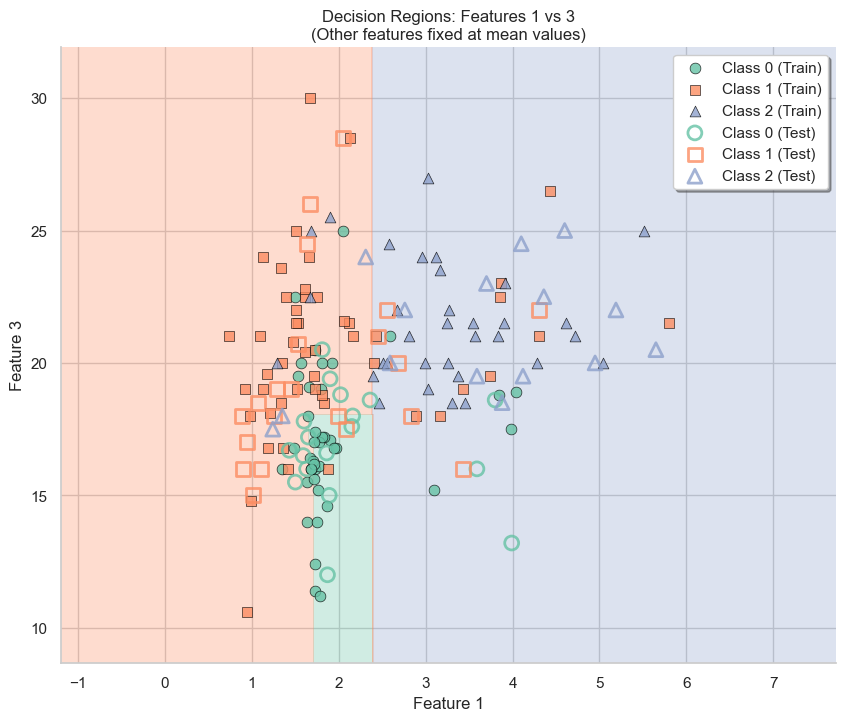

In [12]:
drp.plot_decision_regions(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifier=lgbm, feature_indices=(0, 1))
drp.plot_decision_regions(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifier=lgbm, feature_indices=(0, 2))
drp.plot_decision_regions(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, classifier=lgbm, feature_indices=(1, 3))
plt.show()